In [1]:
from setup import *

# 1. Read data

Activity data

In [2]:
activity = pd.read_csv("./Data/WGS_PCAWG.activities.csv")
activity.index = (activity['Cancer Types'] + "::" + activity['Sample Names']).values

96channel and 80channel SBS signatures

In [3]:
SBS_sig = pd.read_csv("./Data/SBS_signatures.csv")
T2C_ind = SBS_sig.Type.values == "T>C"
non_T2C_ind = SBS_sig.Type != "T>C"
SBS_sig_80c_beforeNorm = SBS_sig.iloc[:, 2:].loc[non_T2C_ind, :].copy()
SBS_sig_80c = SBS_sig_80c_beforeNorm.apply(lambda row: row / SBS_sig_80c_beforeNorm.sum(axis = 0), axis = 1)

SBS_sig = SBS_sig.iloc[:, 2:].copy()

Sequenced WGS FFPE CRC

In [4]:
FFPE_profiles = pd.read_csv ("./Data/LocalFFPE_BeforeCorrection_profiles.csv", sep = "\t")
FFPE_profiles.head(2)

,MutationType,Basic_types,Unrepaired,Repaired,Concordant
0,C>A@A_A,C>A,118,66,11
1,C>A@A_C,C>A,45,21,6


In [5]:
FFPE_profiles.sum()

MutationType    C>A@A_AC>A@A_CC>A@A_GC>A@A_TC>A@C_AC>A@C_CC>A@...
Basic_types     C>AC>AC>AC>AC>AC>AC>AC>AC>AC>AC>AC>AC>AC>AC>AC...
Unrepaired                                                  13280
Repaired                                                     6107
Concordant                                                   1040
dtype: object

## 1.1 Frequency of six basic types of mutation in WGS FFPE samples

In [6]:
df_tmp = FFPE_profiles.groupby('Basic_types').sum()/FFPE_profiles.groupby('Basic_types').sum().sum()
df_tmp = df_tmp.reset_index()

**Read PCAWG-CRCs and compare local FFPE T>C mutation frequency against to PCAWG CRC samples**

(96, 60)


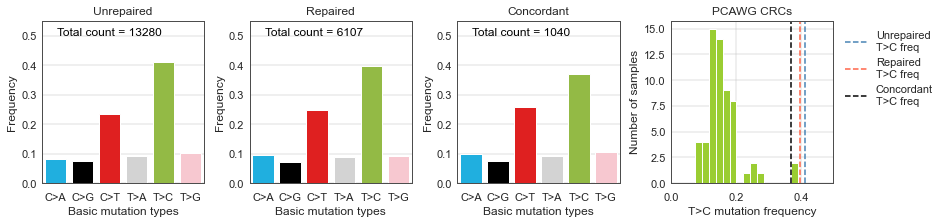

In [7]:
profiles_PCAWG = pd.read_csv ("./Data/WGS_PCAWG.96.csv")
target_index = [sid.split('::')[0] == "ColoRect-AdenoCA" for sid in list(profiles_PCAWG.columns[2:])]
crc_PCAWG = profiles_PCAWG.iloc[:,2:].loc[:, target_index]
print (crc_PCAWG.shape)
crc_PCAWG['Basic_types'] = profiles_PCAWG['Mutation type'].values
df_crc_prop = crc_PCAWG.groupby('Basic_types').sum()/crc_PCAWG.groupby('Basic_types').sum().sum()
df_crc_prop = df_crc_prop.reset_index()
CRC_T2C_prop = df_crc_prop[df_crc_prop["Basic_types"] == "T>C"].iloc[0,1:]

sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.4, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize = (13,3),constrained_layout = True)

colors = ['deepskyblue','black','red','lightgrey','yellowgreen','pink']
basic_types = ['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G']
color_dict = {}
for i, t in enumerate(basic_types):
    color_dict[t] = colors[i]
    
for ax,col in zip ([ax1,ax2,ax3], df_tmp.columns[1:]):

    total_count = FFPE_profiles.groupby('Basic_types').sum().sum()[col]
    sns.barplot(x = "Basic_types", y=col, data=df_tmp,
                 order = basic_types, palette= color_dict, ax = ax)
    ax.set_title(col)
    ax.set_xlabel ("Basic mutation types")
    ax.set_ylabel ("Frequency")
    ax.set_ylim (0,0.55)
    ax.annotate(f'Total count = {total_count}', xy=(0.05, 0.5), color = "black")
ax = ax4
ax.hist(CRC_T2C_prop.values, bins = 15, color = 'yellowgreen')
ax.set_xlim (0,0.5)
ax.set_title ("PCAWG CRCs" )
ax.set_ylabel("Number of samples")
ax.set_xlabel("T>C mutation frequency")
cols = ['steelblue','tomato','black']
for i,col in enumerate(df_tmp.columns[1:]):
    prop = df_tmp[df_tmp["Basic_types"] == "T>C"].iloc[0,1:][col]
    ax.axvline (prop, linestyle = "--", color = cols[i], label = col + "\nT>C freq")
plt.legend(bbox_to_anchor=(1.01, 1),frameon = False)
plt.savefig("./Figures/SFig11b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

# 2. Analysing concordant mutation profile

As matched FF tumour sample is not avaiable, we are using concordant mutations between two FFPE samples as an approximation of true mutational profile of the patient. 

##  2.1 Highly similar profiles shared within CRC subgroups

Before analysing concordant mutation profile, we will look into PCAWG CRC samples to get a better knowledge of CRC mutation catalogues.

<Figure size 936x936 with 0 Axes>

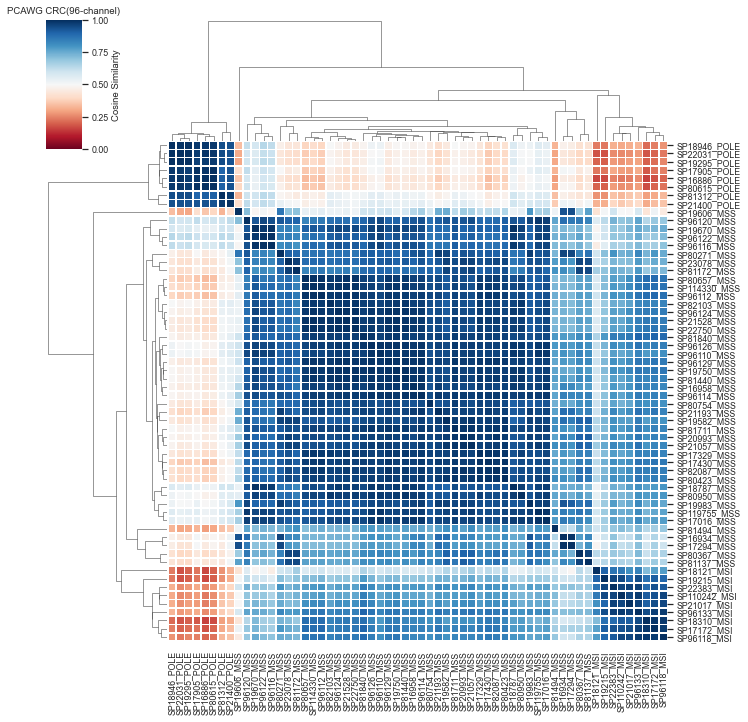

In [8]:
crc_PCAWG = profiles_PCAWG.iloc[:,2:].loc[:, target_index]
crc_PCAWG.columns = [sid.split('::')[1] for sid in crc_PCAWG.columns.values]

POLE_samples = pd.read_csv("./Data/CRC_POLE.samples")
pole = {i.split("..")[1]:1 for i in POLE_samples['CRC.POLE']}

MSI_samples = pd.read_csv("./Data/CRC_MSI.samples")
msi = {i.split("..")[1]:1 for i in MSI_samples['CRC.MSI']}

new_names = crc_PCAWG.columns.values.copy()
for i in range(len(new_names)):
    if msi.get(new_names[i], 0) == 1:
        new_names[i] = new_names[i] + "_MSI"
    elif pole.get (new_names[i], 0) == 1:
        new_names[i] = new_names[i] + "_POLE"        
    else:
        new_names[i] = new_names[i] + "_MSS"
        
crc_PCAWG.columns = new_names
crc_PCAWG.index = profiles_PCAWG['Mutation type'] ## + "@" + profiles_PCAWG['Trinucleotide']
crc_PCAWG_norm = crc_PCAWG/crc_PCAWG.sum()

sim_96c = cosine_similarity(crc_PCAWG_norm.values.T, crc_PCAWG_norm.values.T)

plt.figure(figsize=(13,13))
sns.set(font_scale=0.8)
sns.clustermap(sim_96c, linewidth = 0.5, cmap = "RdBu", vmin = 0, vmax = 1,
                       xticklabels = crc_PCAWG_norm.columns.values, 
                    yticklabels = crc_PCAWG_norm.columns.values,
                   cbar_kws = {'shrink': .6,  'aspect':8,'ticks' : np.linspace(0, 1,5),
                               'label': f"Cosine Similarity"})
plt.title("PCAWG CRC(96-channel)")
plt.savefig("./Figures/SFig12a.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.2 Comparing sample pair similarity within and between CRC subgroups

There are three subtypes have been clearly identified above, namely POLE-CRC, MSS-CRC, MSI-CRC. We next computed the differences of sample-pair consine simialrities within and between subgroup.

In [9]:
def compute_withinGroup_betweenGroup_diff(df_tmp, title = "", plot = False, file= "", legend_flag = True, 
                                          width = 4, height = 1.6):
    targets = ['MSI',"POLE", "MSS"]
    minus_log10_pvalue = []
    
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(width,height), sharey = True)
        sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                             'ytick.major.size': 2,
                                                             'axes.edgecolor': '.3', 
                                                             'axes.linewidth': 1.35,})  
    for i,target in enumerate(targets):
        group, label, sim = [], [], []
        df_tmp1 = df_tmp.loc[:, ## within group data
                            [sample.split ("_")[1] == target for sample in df_tmp.columns]].copy()
        sim_tmp1 = cosine_similarity(df_tmp1.values.T, df_tmp1.values.T) ## cosine similarities within the group
        tri_sim1 = sim_tmp1[np.triu_indices(len(sim_tmp1), k = 1)]
        
        df_tmp2 = df_tmp.loc[:, ## between-group data
                            [sample.split ("_")[1] != target for sample in df_tmp.columns]].copy()
   
        sim_tmp2 = cosine_similarity(df_tmp1.values.T, df_tmp2.values.T) ## cosine similarities with the outgroup
        a, b = sim_tmp2.shape
        tri_sim2 = sim_tmp2.reshape(a * b)
    
        t, p = mannwhitneyu(tri_sim1, tri_sim2, alternative='two-sided') ## difference test
        
        minus_log10_pvalue.append (-np.log10(p))
        if plot:
            mean_value = np.mean (tri_sim1)
            print (f"{title} {target}(n={len(tri_sim1)})\tmean:{mean_value:.2f}")        
            
            customPalette = sns.set_palette(sns.color_palette(['orange', 'silver']))
            ax = [ax1,ax2,ax3][i]
            
            ## making dataframe for the target group:
            sim += list(tri_sim1) + list (tri_sim2)
            label += ['Within group'] * len(tri_sim1) + ['Between group'] * len(tri_sim2)
            group += [target] * (len(tri_sim1) + len(tri_sim2))
            sim_df = pd.DataFrame({"Group": group, "label": label,"Pair-wise_simlarities": sim})
            sns.violinplot(x = 'Group', y = "Pair-wise_simlarities", hue = label, data = sim_df, 
                           ax = ax, palette= customPalette)
            
            ## adding p value on the plot     
            x1, x2 = -0.20, 0.20
            y, h, col = sim_df['Pair-wise_simlarities'].max()+0.1, 0.1, 'black'
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
            ax.text((x1+x2)*.5, y + h + 0.1, 'p={0:1.1e}'.format(p), ha='center', va='bottom', color=col)
    
            sns.despine()
            ax.grid (linestyle='-', linewidth=0.3)
            ax.set_xlabel("")
    
            if target == "MSI": 
                ax.set_ylabel("Similarities of\n" + title + "\nmutations", size = 11, color = "black")
            else:
                ax.set_ylabel("")
        
            if legend_flag:
                if target == "MSS": 
                    ax.legend (bbox_to_anchor=(1.02,1), frameon = False, fontsize=11, ncol = 1)
                else:
                    ax.legend ('', frameon = False)
            else:
                ax.legend ('', frameon = False)
                
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(11)
    if plot:
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig(file, bbox_inches = "tight", dpi = 300)
        plt.show()
    return (minus_log10_pvalue)

all 96-channel MSI(n=36)	mean:0.92
all 96-channel POLE(n=28)	mean:0.96
all 96-channel MSS(n=903)	mean:0.90


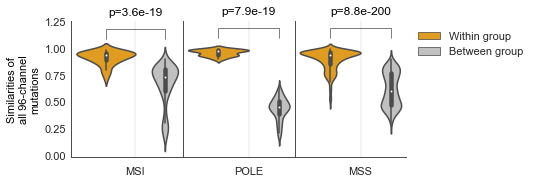

sum (log10 (- p-values):  235.5976265967442


In [10]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.4, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})

a, b, c = compute_withinGroup_betweenGroup_diff(crc_PCAWG_norm.loc[:,:], title = "all 96-channel", 
                                                plot = True, legend_flag = True, width = 6, 
                                                height = 2.5, file = "./Figures/SFig13a.pdf")
total_96c = np.sum(a + b + c)
print ("sum (log10 (- p-values): ", total_96c)

n is the number of possible sample-pairs.

## 2.3 Selecting mutation patterns for classifying CRC subtypes

We then tried to find the mutation types which are conferring the most conserved pattern within each subtype but difference between subgroups. The toal sum of -log10(p value) is used for the search. The higher the value is, the more conserved pattern the mutations hold. 

### 2.3.1 Computing sum of -log10(p value)

In [11]:
df_tmp = pd.DataFrame()
df_tmp['types'] = basic_types[:6]
MSI_minus_log10_P = []
POLE_minus_log10_P = []
MSS_minus_log10_P = []

for tag in df_tmp['types']:
    
    a, b, c = compute_withinGroup_betweenGroup_diff(crc_PCAWG_norm.loc[tag,:], title = tag)
    MSI_minus_log10_P.append(a)
    POLE_minus_log10_P.append(b)
    MSS_minus_log10_P.append(c)
df_tmp['MSI_minus_log10_P'] = MSI_minus_log10_P
df_tmp['POLE_minus_log10_P'] = POLE_minus_log10_P
df_tmp['MSS_minus_log10_P'] = MSS_minus_log10_P
df_tmp['Total'] = df_tmp['MSI_minus_log10_P'] + df_tmp['POLE_minus_log10_P'] + df_tmp['MSS_minus_log10_P']
df_tmp_sorted = df_tmp.sort_values("Total")
df_tmp_sorted

,types,MSI_minus_log10_P,POLE_minus_log10_P,MSS_minus_log10_P,Total
5,T>G,19.418379,18.099637,121.449464,158.967480
4,T>C,21.872906,14.978663,151.537199,188.388768
1,C>G,19.043951,6.793004,221.209581,247.046536
3,T>A,21.213315,16.813817,215.309215,253.336348
2,C>T,11.155290,18.099637,255.131923,284.386849
0,C>A,22.801992,18.099637,245.982547,286.884176


T>G MSI(n=36)	mean:0.96
T>G POLE(n=28)	mean:0.99
T>G MSS(n=903)	mean:0.91


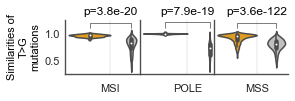

T>C MSI(n=36)	mean:0.97
T>C POLE(n=28)	mean:0.94
T>C MSS(n=903)	mean:0.94


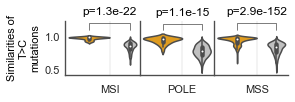

C>G MSI(n=36)	mean:0.97
C>G POLE(n=28)	mean:0.91
C>G MSS(n=903)	mean:0.97


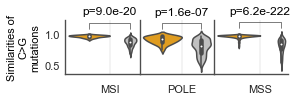

T>A MSI(n=36)	mean:0.98
T>A POLE(n=28)	mean:0.97
T>A MSS(n=903)	mean:0.96


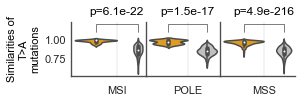

C>T MSI(n=36)	mean:0.94
C>T POLE(n=28)	mean:0.98
C>T MSS(n=903)	mean:0.98


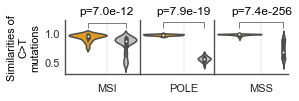

C>A MSI(n=36)	mean:0.97
C>A POLE(n=28)	mean:1.00
C>A MSS(n=903)	mean:0.97


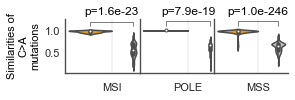

In [12]:
for tag in df_tmp_sorted['types'].values:
    a, b, c = compute_withinGroup_betweenGroup_diff(crc_PCAWG_norm.loc[tag,:], title = tag, plot = True, 
                                                   legend_flag = False, height = 1, 
                                                    file = "./Figures/SFig13b_1" + tag + ".pdf")

In [13]:
## C>A and C>T together
a, b, c = compute_withinGroup_betweenGroup_diff(crc_PCAWG_norm.loc[df_tmp_sorted['types'].values[5:],:], 
                                                title = "C>A and C>T")
total_top2 = np.sum(a + b + c)
print ("sum (log10 (- p-values) using C>A and C>T : ", total_top2)

sum (log10 (- p-values) using C>A and C>T :  286.88417613456886


### 2.3.2 Rank the mutation types according to sum -log10(p value)

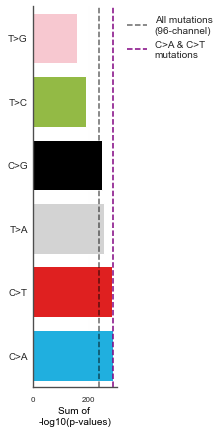

In [14]:
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.01, 'grid.color': '.7', 
                                                             'ytick.major.size': 2,
                                                             'axes.edgecolor': '.3', 
                                                             'axes.linewidth': 1.35,})
f, ax1 = plt.subplots(figsize = (1.5,7))
sns.barplot(data=df_tmp_sorted, y = "types", x="Total", 
                  palette= color_dict, ax = ax1)

ax1.set_xlabel("Sum of \n-log10(p-values)", color = "black", size = 10)
ax1.set_ylabel("")

sns.despine()
ax1.axvline (total_96c, linestyle = "--", label = "All mutations\n(96-channel)", color = "black", alpha = 0.6)
ax1.axvline(total_top2, linestyle = "--", label = "C>A & C>T\nmutations", color = "purple")
plt.legend(bbox_to_anchor=(1.01,1), fontsize = 10, frameon = False)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.savefig ("./Figures/SFig13b_2.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

### 2.3.3 Clustering using only C>A and C>T

We then use mutation with top two conserved patterns to cluster the CRC samples again.

<Figure size 936x936 with 0 Axes>

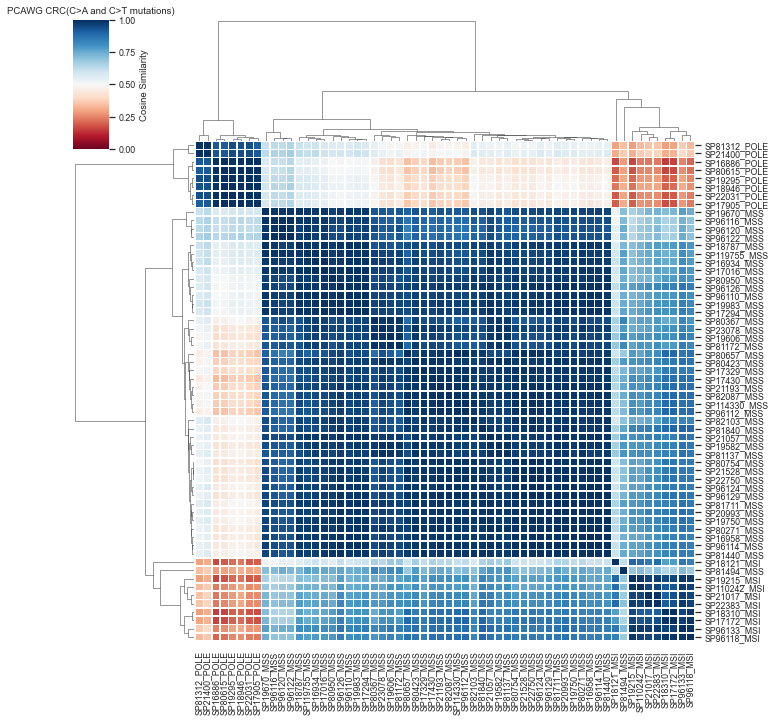

In [15]:
tag = ["C>A", "C>T"]
df_tmp = crc_PCAWG_norm.loc[tag,:]
sim_32c = cosine_similarity(df_tmp.values.T, df_tmp.values.T)

plt.figure(figsize=(13,13))
sns.set(font_scale=0.8)
sns.clustermap(sim_32c, linewidth = 0.5, cmap = "RdBu", vmin = 0, vmax = 1,
                       xticklabels = crc_PCAWG_norm.columns.values, 
                    yticklabels = crc_PCAWG_norm.columns.values,
                   cbar_kws = {'shrink': .6,  'aspect':8,'ticks' : np.linspace(0, 1,5),
                               'label': f"Cosine Similarity"})
plt.title("PCAWG CRC(C>A and C>T mutations)")
plt.savefig ("./Figures/SFig12b.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 2.4 Comparing concordant C>A mutations to CRC subgroups

We compared concordant C>A mutation pattern to PCAWG CRCs and found the tumour belongs to MSS-CRC.

In [16]:
def SBS96_plot_specified(sig, name = "", label = "", norm = "False", file = False, width = 10, height = 2, 
                         bar_width = 0.5, grid = 0.4, s = 8, xticks = False):
    channel = 96
    col_set = ['deepskyblue','black','red','lightgrey','yellowgreen','pink']
    col_list = []
    for i in range (len(col_set)):
        col_list += [col_set[i]] * 16
    
    sns.set(rc={"figure.figsize":(width, height)})
    sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": grid, 'grid.color': '.7', 'ytick.major.size': 2,
                                                 'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})

    channel6 = ['C>A','C>G','C>T','T>A','T>C','T>G']
    channel96 = ['ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT', 'GCA',
               'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT', 'ACA', 'ACC',
               'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT', 'GCA', 'GCC', 'GCG',
               'GCT', 'TCA', 'TCC', 'TCG', 'TCT', 'ACA', 'ACC', 'ACG', 'ACT',
               'CCA', 'CCC', 'CCG', 'CCT', 'GCA', 'GCC', 'GCG', 'GCT', 'TCA',
               'TCC', 'TCG', 'TCT', 'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC',
               'CTG', 'CTT', 'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG',
               'TTT', 'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT',
               'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT', 'ATA',
               'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT', 'GTA', 'GTC',
               'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT']
    
    ## plot the normalized version if asked:
    if norm == "True":
        normed_sig = sig / np.sum(sig)
        plt.bar(range(channel), normed_sig , width = bar_width, color = col_list)
        plt.xticks(rotation = 90, size = 7, weight='bold')
        plt.ylim (0,np.max(normed_sig) * 1.15)
        plt.annotate (name,(80, np.max(normed_sig) -0.015), size = 11)
        plt.ylabel("Frequency")
    ## plot the original version:
    else:
        plt.bar(range(channel), sig , width = bar_width, color =col_list)
        plt.xticks(rotation=90, size = 7, weight='bold')
        plt.ylim (0,np.max(sig)*1.15)
        
        if  np.round(np.sum (sig)) != 1:
            plt.annotate ('Total Count : ' + format(np.sum(sig), ','), (0, np.max(sig)*0.75), size = 11)
        plt.ylabel("Number of\nSBSs")
        plt.annotate (name,(0, np.max(sig)))
    if xticks:
        plt.xticks(range(channel), channel96, rotation = 90, ha = "center", va= "center",  size = 7)
    else:
        plt.xticks([], [])
        
    plt.yticks( va= "center",  size = 9)
    ## plot the bar annotation:
    text_col = ["black","w","w","black","black","black"]
    for i in range(6):
        
        left, width = 0 + 1/6 * i + 0.001, 1/6 - 0.002
        
        bottom, height = 1.003, 0.14
        right = left + width
        top = bottom + height
        ax = plt.gca()
        
        p = plt.Rectangle((left, bottom), width, height, fill=True, color = col_set[i])
        p.set_transform(ax.transAxes)
            
        p.set_clip_on(False)
        ax.add_patch(p)
        ax.text(0.5 * (left + right), 0.5 * (bottom + top), channel6[i], color = text_col[i], weight='bold',size = s,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

        if channel6[i] == "T>C":
            bottom, height = 0, 1
            p = plt.Rectangle((left, bottom), width, height, fill=True, color = 'lightgrey', alpha = 0.3)
            p.set_transform(ax.transAxes)
            p.set_clip_on(False)
            ax.add_patch(p)
            ax.text(0.5 * (left + right), 0.1 * (bottom + top), 'Removed', color = 'black', size = 11,
                horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
            
    ## plot the name annotation
    if label != "":
        left, width = 1.003, 0.05
        bottom, height = 0, 1
        right = left + width
        top = bottom + height
        ax = plt.gca()
        p = plt.Rectangle((left, bottom), width, height, fill=True, color = "silver",alpha = 0.3)
        p.set_transform(ax.transAxes)
        p.set_clip_on(False)
        ax.add_patch(p)
        ax.text(0.502 * (left + right), 0.5 * (bottom + top), label, color = "black",size = 11,
            horizontalalignment='center',verticalalignment='center',transform=ax.transAxes , rotation = 90)

    ax.margins(x=0.002, y=0.002)
    plt.tight_layout()
    if file:
        plt.savefig(file, bbox_inches = "tight", dpi = 300)
    plt.show()

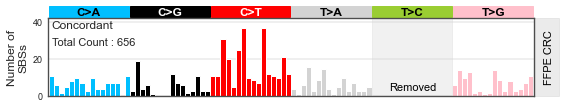

In [17]:
T2C_ind = ["T>C" == i for i in FFPE_profiles["Basic_types"]]
C2T_ind = ["C>T" == i for i in FFPE_profiles["Basic_types"]]
concordant_profile = FFPE_profiles['Concordant'].to_numpy().copy()
concordant_profile[T2C_ind] = 0
SBS96_plot_specified(concordant_profile, bar_width = 1, label = 'FFPE CRC',
                     name = "Concordant", s = 12, width = 8, height = 1.7, file = "./Figures/Fig4a_1.pdf")

In [18]:
def compute_withinGroup_betweenGroup_diff2(df_tmp, compare_array, compare_label, title = "", 
                                           plot = False, legend_flag = True, 
                                          width = 4, height = 1.6):
    targets = ['POLE','MSI',"MSS"]
    minus_log10_pvalue = []
    
    if plot:
        fig, axes = plt.subplots(1,len(targets), figsize=(width,height), sharey = True)
        sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                             'ytick.major.size': 2,
                                                             'axes.edgecolor': '.3', 
                                                             'axes.linewidth': 1.35,})
    print (df_tmp.shape)    
    for i, target in enumerate(targets):
        group, label, sim = [], [], []
        df_tmp1 = df_tmp.loc[:, ## within group data
                            [sample.split ("_")[1] == target for sample in df_tmp.columns]].copy()
        sim_tmp1 = cosine_similarity(df_tmp1.values.T, df_tmp1.values.T) ## cosine similarities within the group
        tri_sim1 = sim_tmp1[np.triu_indices(len(sim_tmp1), k = 1)]
        
        ## Compare concordant profile with within group profiles:
        compare_results = []
        for col in df_tmp1:
            cs_com = cosine_similarity (compare_array.reshape(1,len(compare_array)),
                                        df_tmp1[col].to_numpy().reshape(1,len(compare_array)))
            compare_results.append(cs_com[0][0])
                                                
        compare_mean = np.mean(np.array(compare_results))
        compare_error = np.std(np.array(compare_results))
        
        df_tmp2 = df_tmp.loc[:, ## between-group data
                            [sample.split ("_")[1] != target for sample in df_tmp.columns]].copy()
   
        sim_tmp2 = cosine_similarity(df_tmp1.values.T, df_tmp2.values.T) ## cosine similarities with the outgroup
        a, b = sim_tmp2.shape
        tri_sim2 = sim_tmp2.reshape(a * b)
    
        t, p = mannwhitneyu(tri_sim1, tri_sim2, alternative='two-sided') ## difference test
        
        minus_log10_pvalue.append (-np.log10(p))

        if plot:
            customPalette = sns.set_palette(sns.color_palette(['orange', 'silver']))
            ax = axes[i]
            ## making dataframe for the target group:
            sim += list(tri_sim1) + list (tri_sim2)
            label += ['Within group'] * len(tri_sim1) + ['Between group'] * len(tri_sim2)
            group += [target] * (len(tri_sim1) + len(tri_sim2))
            sim_df = pd.DataFrame({"Group": group, "label": label,"Pair-wise_simlarities": sim})
            sns.boxenplot(x = 'Group', y = "Pair-wise_simlarities", hue = label, data = sim_df, 
                             ax = ax, palette= customPalette)
                        
            ax.errorbar (-0.2, compare_mean, yerr = compare_error, fmt = "o", 
                         color = "tomato", label = compare_label)
            
            ## adding p value on the plot     
            x1, x2 = -0.20, 0.20
            y, h, col = sim_df['Pair-wise_simlarities'].max()+0.1, 0.1, 'black'
            ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
            ax.text((x1+x2)*.5, y + h + 0.1, 'p={0:1.1e}'.format(p), ha='center', 
                    va='bottom', color=col, size = 10)
            
            sns.despine()
            ax.grid (linestyle='-', linewidth=0.3)
            ax.set_xlabel("")
    
            if target == "POLE": 
                ax.set_ylabel("Cosine similarities of\n" + title + " mutations", size = 10, color = "black")
            else:
                ax.set_ylabel("")
        
            if legend_flag:
                if target == "MSS":
                    ax.legend (bbox_to_anchor=(1.2, -0.17), frameon = False, fontsize=10, ncol = 3)
                else:
                    ax.legend ('', frameon = False)
            else:
                ax.legend ('', frameon = False)
                
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(10)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(9)
    if plot:
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.savefig("./Figures/Fig4b.pdf", bbox_inches = "tight", dpi = 300)
        plt.show()
        
    return (minus_log10_pvalue)

(16, 60)


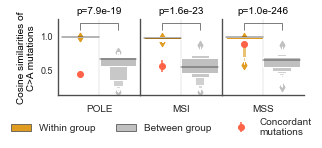

In [19]:
tag = "C>A"
array_ind = [i in tag for i in FFPE_profiles['Basic_types']]
FFPE_profiles['Concordant'][array_ind].to_numpy()
a,b,c = compute_withinGroup_betweenGroup_diff2(crc_PCAWG_norm.loc[tag,:], 
                                               compare_array = FFPE_profiles['Concordant'][array_ind].to_numpy(),
                                               compare_label = "Concordant\nmutations",
                                               title = tag, plot = True,
                                                legend_flag = True, width = 4.4, height = 1.4)

### Active signatures in the sample

We compare concordant C>A mutation profiles to all MSS CRCs for the best match and take active signatures in the best match as the active signature for our CRC patient.

In [20]:
crc_PCAWG_norm_mss = crc_PCAWG_norm.loc[:,['MSS' in col for col in crc_PCAWG_norm.columns]]    
cs = []
for col in crc_PCAWG_norm_mss.columns:
    cs_tmp = cosine_similarity(crc_PCAWG_norm_mss[col].to_numpy()[:16].reshape(1,16),
                                        FFPE_profiles['Concordant'][array_ind].to_numpy().reshape(1,16))
    cs.append(cs_tmp[0][0])
    
cs_df_concordant_crc_mss = pd.DataFrame({"sample":crc_PCAWG_norm_mss.columns.values,
                                         "similarity_to_concordant" : cs})
cs_df_concordant_crc_mss_sorted = cs_df_concordant_crc_mss.sort_values('similarity_to_concordant',
                                                                       ascending = False)
best_match_crc_mss_to_concodant = cs_df_concordant_crc_mss_sorted['sample'].values[0]
cs_df_concordant_crc_mss_sorted.head(1), best_match_crc_mss_to_concodant

(         sample  similarity_to_concordant
 14  SP17430_MSS                  0.929651,
 'SP17430_MSS')

In [21]:
mss_pid = best_match_crc_mss_to_concodant
mss_pid_tmp = mss_pid.split("_")[0]
active_sig_ind = activity.loc["ColoRect-AdenoCA::" + mss_pid_tmp][3:].values > 0
active_sig_CRC_FFPE = activity.columns[3:][active_sig_ind].values
mss_pid_tmp, active_sig_CRC_FFPE

('SP17430', array(['SBS1', 'SBS5', 'SBS40'], dtype=object))

# 3. Correction of FFPE samples

We next applied our FFPE noise correction method on unrepaired and repaired FFPE samples we sequenced from one CRC patient.

## 3.1 Correction on unrepaired FFPE CRC

In [22]:
unrepaired_before_correction = FFPE_profiles['Unrepaired'].to_numpy().copy()

unrepaired_after_correction, corrected_profiles_df = correct_FFPE_profile(V = unrepaired_before_correction, 
                                                                          W1 = ffpe_sig_unrepaired,
                                                                          sample_id= 'unrepaired')

Due to the overwhelming T>C mutations, the main signal in C>T channels are not visible. Thus, we remove the T>C channels in our main figure to highlight the signal.

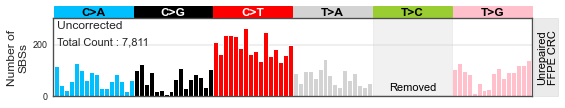

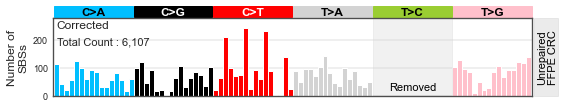

Before: [[0.90604565]] 	After: [[0.94839397]]


In [23]:
unrepaired_before_correction[T2C_ind] = 0
unrepaired_after_correction[T2C_ind] = 0

SBS96_plot_specified(unrepaired_before_correction, bar_width = 1, label = 'Unrepaired\nFFPE CRC',
                     name = "Uncorrected", s = 12, width = 8,
                     height = 1.7, file = "./Figures/Fig4a_2.pdf")
SBS96_plot_specified(unrepaired_after_correction, bar_width = 1, label = 'Unrepaired\nFFPE CRC',
                     name = "Corrected", file = "./Figures/Fig4a_3.pdf",
                     s = 12,width = 8, height = 1.7)

unrepaired_cs_before = cosine_similarity (concordant_profile[C2T_ind].reshape(1,16),
                   unrepaired_before_correction[C2T_ind].reshape(1,16))
unrepaired_cs_after = cosine_similarity (concordant_profile[C2T_ind].reshape(1,16),
                   unrepaired_after_correction[C2T_ind].reshape(1,16))
print ("Before:", unrepaired_cs_before, "\tAfter:", unrepaired_cs_after)

Impact of decompostion using corrected and uncorrected FFPEs

In [24]:
df_unrepaired_act = pd.DataFrame()
channel_num = sum(non_T2C_ind)

act_sig =  active_sig_CRC_FFPE
active_sig_num = len(act_sig)

df_unrepaired_act['active_sig']= act_sig

## activities by uncorrected profile:
npr.seed(123)

uncorrected_v = FFPE_profiles['Unrepaired'][non_T2C_ind].to_numpy()
h, kl_loss = sig_refitting(V = uncorrected_v.reshape(channel_num, 1), 
                            W = SBS_sig_80c.loc[non_T2C_ind, act_sig].to_numpy(), precision = 0.99)
df_unrepaired_act['Uncorrected'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))

## activities by corrected profile:
corrected_v = unrepaired_after_correction[non_T2C_ind]
h, kl_loss = sig_refitting(V = corrected_v.reshape(channel_num, 1), 
                            W = SBS_sig_80c.loc[non_T2C_ind, act_sig].to_numpy(), precision = 0.99)
df_unrepaired_act['Corrected'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))

concordant_v = FFPE_profiles['Concordant'][non_T2C_ind].to_numpy()    
h, kl_loss = sig_refitting(V = concordant_v.reshape(channel_num, 1), 
                            W = SBS_sig_80c.loc[non_T2C_ind, act_sig].to_numpy(), precision = 0.99)

df_unrepaired_act['Concordant'] = h.reshape(active_sig_num)/np.sum(h.reshape(active_sig_num))

df_unrepaired_act = df_unrepaired_act.set_index('active_sig')
df_unrepaired_act

,Uncorrected,Corrected,Concordant
active_sig,,,
SBS1,0.055255,0.110831,0.158675
SBS5,0.934291,0.339738,0.513278
SBS40,0.010454,0.549431,0.328046


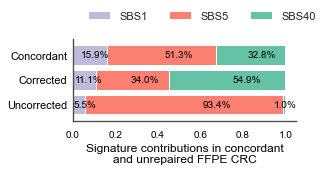

In [25]:
df_tmp = df_unrepaired_act.T
sns.set(rc={"figure.figsize":(4, 1.5)})
sns.set(style="white", color_codes=True, rc={"grid.linewidth": 0.2, 'grid.color': '.7', 'ytick.major.size': 2,
                                                 'axes.edgecolor': '.3', 'axes.linewidth': 1.35,})
ax = df_tmp.plot(kind = 'barh', stacked = True, 
                        #title = 'Percentage of mutation subtypes', 
                        mark_right = True,
                        width = 0.8,
                        color = sns.color_palette("Set3")[2:4] + [sns.color_palette("Set2")[0]])

plt.yticks(np.arange(len(df_tmp.index)), [i.split(" ")[0] for i in df_tmp.index], 
           color = "black", size = 11)

df_rel = df_tmp * 100

text_color = ['black','black','black']

for j,n in enumerate(df_rel): 
    for i, (cs, ab, pc) in enumerate(zip(df_tmp.cumsum(1)[n],  
                                         df_tmp[n], df_rel[n])): 
        if pc > 6:
            plt.text (cs - ab / 3, i, str(np.round(pc, 1)) + '%',  
                      va = 'center', ha = 'center', color = text_color[j], size = 10)
        if pc < 6:
            plt.text (cs, i, str(np.round(pc, 1)) + '%',  
                      va = 'center', ha = 'center', color = text_color[j], size = 10)
sns.despine()
plt.xticks (size = 10, color = "black")
plt.xlabel("Signature contributions in concordant\nand unrepaired FFPE CRC", 
           color = "black", size = 12)
plt.legend (bbox_to_anchor = (0.025, 1.1), ncol = 3, frameon = False)
plt.savefig("./Figures/Fig4c.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## 3.2 Correction on repaired FFPE CRC

In [26]:
repaired_before_correction = FFPE_profiles['Repaired'].to_numpy().copy()
repaired_after_correction, repaired_correction_profiles = correct_FFPE_profile(V = repaired_before_correction, 
                                                                              W1 = ffpe_sig_repaired,
                                                                              sample_id= 'repaired')

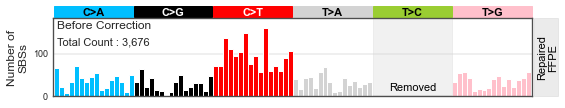

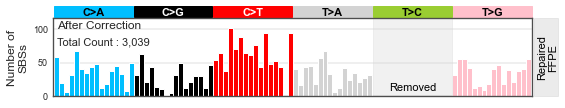

Before: [[0.95362737]] 	After: [[0.81955678]]


In [27]:
repaired_before_correction[T2C_ind] = 0
repaired_after_correction[T2C_ind] = 0

SBS96_plot_specified(repaired_before_correction, bar_width = 1, label = 'Repaired\nFFPE',
                      name = "Before Correction", file = "./Figures/SFig14a.pdf",
                     s = 11, width = 8, height = 1.7)
SBS96_plot_specified(repaired_after_correction, bar_width = 1, label = 'Repaired\nFFPE',
                    name = "After Correction",  file = "./Figures/SFig14b.pdf",
                     s = 11,width = 8, height = 1.7)

repaired_cs_before = cosine_similarity (concordant_profile[C2T_ind].reshape(1,16),
                   repaired_before_correction[C2T_ind].reshape(1,16))
repaired_cs_after = cosine_similarity (concordant_profile[C2T_ind].reshape(1,16),
                   repaired_after_correction[C2T_ind].reshape(1,16))

print ("Before:", repaired_cs_before, "\tAfter:", repaired_cs_after)

## 3.3 Compare uncorrected and corrected results to positive controls

The comparison will be made with:
+ concordant mutations as the fisrt positive control;
+ all CRC-MSS samples as within-subtype sharing very similar mutation patterns

### 3.3.1 Compare to concordant mutations

In [28]:
acc_concordant = pd.DataFrame()
acc_concordant['FFPE'] = ['Unrepaired'] * 2 + ['Repaired'] * 2
acc_concordant['Groups'] = ['Before correction', 'After correction'] * 2
acc_concordant['Cosine_similarity'] = [unrepaired_cs_before[0][0], unrepaired_cs_after[0][0],
                                      repaired_cs_before[0][0], repaired_cs_after[0][0]]
acc_concordant

,FFPE,Groups,Cosine_similarity
0,Unrepaired,Before correction,0.906046
1,Unrepaired,After correction,0.948394
2,Repaired,Before correction,0.953627
3,Repaired,After correction,0.819557


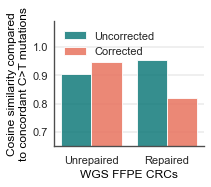

In [29]:
f, ax = plt.subplots (figsize=(2.7,2.3))
sns.set(style="whitegrid", color_codes=True, rc={"grid.linewidth": 0.5, 'grid.color': '.7', 
                                                 'ytick.major.size': 2,'axes.edgecolor': '.3', 
                                                 'axes.linewidth': 1})
sns.barplot(data = acc_concordant, x = "FFPE", y = "Cosine_similarity", hue = "Groups", ax = ax,
           palette = {"Before correction" : "darkcyan", "After correction" : "tomato"}, alpha = 0.85)
plt.ylim (0.65,1.09)
plt.xlabel("WGS FFPE CRCs", size = 12, color = "black" )
sns.despine()
handles, labels = ax.get_legend_handles_labels()

plt.legend(loc = "upper left",handles = handles,  
           labels = ["Uncorrected", "Corrected"],frameon = False, fontsize = 11)
plt.ylabel("Cosine similarity compared\nto concordant C>T mutations", size = 12, color = "black")
plt.savefig("./Figures/Fig4d.pdf",bbox_inches = "tight", dpi = 300)

plt.show()

### 3.3.2 Compare to MSS-CRCs

6.1969855253481155e-12
2.0646989982315572e-15


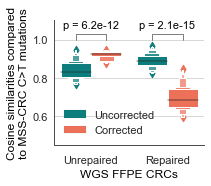

In [30]:
crc_PCAWG_norm_MSS =  crc_PCAWG_norm.loc[:,
                                        ["MSS" == i.split("_")[1] for i in crc_PCAWG_norm.columns.values]].copy()
mss_acc = []
label = []
group = []

for col in crc_PCAWG_norm_MSS:
    n = np.sum(C2T_ind)
    mss_tmp = crc_PCAWG_norm_MSS.loc[C2T_ind, col].to_numpy()
    ## unrepaired before correction
    cs_tmp= cosine_similarity (mss_tmp.reshape(1,n),
                                unrepaired_before_correction[C2T_ind].reshape(1,n))
    mss_acc.append(cs_tmp[0][0])
    label.append("Unrepaired")
    group.append("Before correction")
    
    ## unrepaired after correction
    cs_tmp = cosine_similarity (mss_tmp.reshape(1,n),
                                unrepaired_after_correction[C2T_ind].reshape(1,n))
    mss_acc.append(cs_tmp[0][0])
    label.append("Unrepaired")
    group.append("After correction")
    
    ## repaired before correction
    cs_tmp= cosine_similarity (mss_tmp.reshape(1,n),
                                repaired_before_correction[C2T_ind].reshape(1,n))
    mss_acc.append(cs_tmp[0][0])
    label.append("Repaired")
    group.append("Before correction")
    
    ## repaired after correction
    cs_tmp = cosine_similarity (mss_tmp.reshape(1,n),
                                repaired_after_correction[C2T_ind].reshape(1,n))
    mss_acc.append(cs_tmp[0][0])
    label.append("Repaired")
    group.append("After correction")

acc_MSS = pd.DataFrame({"FFPE":label, "Group":group, "Cosine_similarity" : mss_acc})

## sig test (Unrepaired):
ind1 = [label == "Unrepaired" and group == "Before correction" for label, group in zip 
       (acc_MSS['FFPE'], acc_MSS['Group'])]

unrepaired_bef = acc_MSS.loc[ind1,"Cosine_similarity"].values

ind2 = [label == "Unrepaired" and group == "After correction" for label, group in zip 
       (acc_MSS['FFPE'], acc_MSS['Group'])]

unrepaired_aft = acc_MSS.loc[ind2,"Cosine_similarity"].values

t_unrepaired, p_unrepaired = mannwhitneyu(unrepaired_bef, unrepaired_aft, 
                                          alternative='two-sided') ## difference test
print (p_unrepaired)

## sig test (Repaired):

ind3 = [label == "Repaired" and group == "Before correction" for label, group in zip 
       (acc_MSS['FFPE'], acc_MSS['Group'])]

repaired_bef = acc_MSS.loc[ind3,"Cosine_similarity"].values

ind4 = [label == "Repaired" and group == "After correction" for label, group in zip 
       (acc_MSS['FFPE'], acc_MSS['Group'])]

repaired_aft = acc_MSS.loc[ind4,"Cosine_similarity"].values

t_repaired, p_repaired = mannwhitneyu(repaired_bef, repaired_aft, 
                                      alternative='two-sided') ## difference test
print (p_repaired)

## plot
f, ax = plt.subplots (figsize=(2.7,2.3))
sns.boxenplot(data = acc_MSS, x = "FFPE", y = "Cosine_similarity", hue = "Group", ax = ax,
           palette = {"Before correction" : "darkcyan", "After correction" : "tomato"}, linewidth = .1, saturation = 0.8)

x1, x2 = -0.20, 0.20
y, h, col = 1, 0.03, 'black'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
if p_unrepaired >= 1e-16:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p = {0:1.1e}'.format(p_unrepaired), ha='center', 
                    va='bottom', color=col, size = 11)
else:
     ax.text((x1+x2)*.5, y + h + 0.02, 'p < 1e-16', ha='center', 
                    va='bottom', color=col, size = 11)
        
x1, x2 = 0.8, 1.2
y, h, col = 1 , 0.03, 'black'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)

if p_repaired >= 1e-16:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p = {0:1.1e}'.format(p_repaired), ha='center', 
                    va='bottom', color=col, size = 11)
else:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p < 1e-16', ha='center', 
                    va='bottom', color=col, size = 11)

handles, labels = ax.get_legend_handles_labels()

plt.legend(loc = "lower left",handles = handles,
           labels = ["Uncorrected", "Corrected"],frameon = False, fontsize = 11)

plt.ylim (0.45,1.1)
plt.xlabel("WGS FFPE CRCs", size = 12, color = "black" )
sns.despine()
plt.ylabel("Cosine similarities compared\nto MSS-CRC C>T mutations", size = 12, color = "black")
plt.savefig("./Figures/Fig4e.pdf",bbox_inches = "tight", dpi = 300)
plt.show()

In [31]:
acc_MSS.groupby(["Group", "FFPE"]).mean()


Cosine_similarity
Group             FFPE                         
After correction  Repaired             0.695158
                  Unrepaired           0.919971
Before correction Repaired             0.892915
                  Unrepaired           0.841392

### 3.3.3 Compare before and after correction results from simulated FFPE MSS-CRCs

We also checked the correction results in simulated MSS-CRC FFPE samples.

In [32]:
## Original samples:
crc_PCAWG_MSS = crc_PCAWG.loc[:,
                            ["MSS" == i.split("_")[1] for i in crc_PCAWG_norm.columns.values]].copy()
crc_PCAWG_MSS.head(1)

,SP114330_MSS,SP96112_MSS,SP96120_MSS,SP96124_MSS,SP19670_MSS,SP16934_MSS,SP20993_MSS,SP19983_MSS,SP96122_MSS,SP119755_MSS,...,SP81840_MSS,SP80657_MSS,SP81494_MSS,SP81711_MSS,SP80423_MSS,SP80754_MSS,SP81440_MSS,SP80950_MSS,SP82103_MSS,SP81137_MSS
Mutation type,,,,,,,,,,,,,,,,,,,,,
C>A,246,152,733,204,429,343,359,503,619,503,...,205,173,373,411,311,234,165,225,240,280


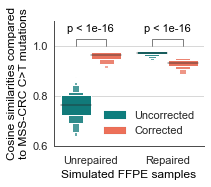

In [33]:
## simulated samples:
simulated_df_unrepaired = pd.read_csv ("./Data/simulated_PCAWG_FFPE_unrepaired.csv")
simulated_df_repaired= pd.read_csv ("./Data/simulated_PCAWG_FFPE_repaired.csv")

## corrected samples:
unrepaired_profiles_corrected = pd.read_csv("./Data/unrepaired_profiles_corrected.csv", sep ="\t")
repaired_profiles_corrected = pd.read_csv("./Data/repaired_profiles_corrected.csv", sep ="\t")

simulated_CRC_MSS_unrepaired_before_correction = pd.DataFrame()
simulated_CRC_MSS_repaired_before_correction = pd.DataFrame()

simulated_CRC_MSS_unrepaired_after_correction = pd.DataFrame()
simulated_CRC_MSS_repaired_after_correction = pd.DataFrame()

for col in crc_PCAWG_MSS.columns:
    sp_id = col.split ("_")[0]
    full_id = "ColoRect-AdenoCA::" + sp_id 
    simulated_CRC_MSS_unrepaired_before_correction[col] = simulated_df_unrepaired[full_id].values
    simulated_CRC_MSS_repaired_before_correction[col] = simulated_df_repaired[full_id].values
    
    simulated_CRC_MSS_unrepaired_after_correction[col] = unrepaired_profiles_corrected[full_id].values
    simulated_CRC_MSS_repaired_after_correction[col] = repaired_profiles_corrected[full_id].values

mss_acc = []
label = []
group = []
samples = []

## comparing every sample to the remaining CRC-MSS and collect data for each comparison.
for current_sample_id in crc_PCAWG_norm_MSS.columns:
    for col in crc_PCAWG_norm_MSS.columns:
        if col != current_sample_id:
            n = np.sum(C2T_ind)
            samples += [current_sample_id] * 4
    
            mss_tmp = crc_PCAWG_norm_MSS.loc[C2T_ind, col].to_numpy()
        
            ## simulated unrepaired before correction
            cs_tmp = cosine_similarity (mss_tmp.reshape(1, n),
                                simulated_CRC_MSS_unrepaired_before_correction[col][C2T_ind].to_numpy().reshape(1,n))
            mss_acc.append(cs_tmp[0][0])
            label.append("Unrepaired")
            group.append("Before correction")
    
            ## unrepaired after correction
            cs_tmp = cosine_similarity (mss_tmp.reshape(1, n),
                                simulated_CRC_MSS_unrepaired_after_correction[col][C2T_ind].to_numpy().reshape(1,n))
            mss_acc.append(cs_tmp[0][0])
            label.append("Unrepaired")
            group.append("After correction")
    
            ## simulated repaired before correction
            cs_tmp= cosine_similarity (mss_tmp.reshape(1, n),
                                simulated_CRC_MSS_repaired_before_correction[col][C2T_ind].to_numpy().reshape(1,n))
            mss_acc.append(cs_tmp[0][0])
            label.append("Repaired")
            group.append("Before correction")
    
            ## repaired after correction
            cs_tmp = cosine_similarity (mss_tmp.reshape(1, n),
                                simulated_CRC_MSS_repaired_after_correction[col][C2T_ind].to_numpy().reshape(1,n))
            mss_acc.append(cs_tmp[0][0])
            label.append("Repaired")
            group.append("After correction")
            
## building dataframe and difference test            
acc_MSS_simulated = pd.DataFrame({"samples" : samples,"FFPE" : label, "Group" : group, "Cosine_similarity" : mss_acc})

## sig test (Unrepaired):
simulated_ind1 = [label == "Unrepaired" and group == "Before correction" for label, group in zip 
       (acc_MSS_simulated['FFPE'], acc_MSS_simulated['Group'])]

unrepaired_bef = acc_MSS_simulated.loc[simulated_ind1,"Cosine_similarity"].values

simulated_ind2 = [label == "Unrepaired" and group == "After correction" for label, group in zip 
       (acc_MSS_simulated['FFPE'], acc_MSS_simulated['Group'])]

unrepaired_aft = acc_MSS_simulated.loc[simulated_ind2,"Cosine_similarity"].values

t_unrepaired_simulated, p_unrepaired_simulated = mannwhitneyu(unrepaired_bef, unrepaired_aft, 
                                          alternative='two-sided') ## difference test

## sig test (Repaired):

simulated_ind3 = [label == "Repaired" and group == "Before correction" for label, group in zip 
       (acc_MSS_simulated['FFPE'], acc_MSS_simulated['Group'])]

repaired_bef = acc_MSS_simulated.loc[simulated_ind3,"Cosine_similarity"].values

simulated_ind4 = [label == "Repaired" and group == "After correction" for label, group in zip 
       (acc_MSS_simulated['FFPE'], acc_MSS_simulated['Group'])]

repaired_aft = acc_MSS_simulated.loc[simulated_ind4,"Cosine_similarity"].values

t_repaired_simulated, p_repaired_simulated = mannwhitneyu(repaired_bef, repaired_aft, 
                                      alternative='two-sided') ## difference test

## plot
f, ax = plt.subplots (figsize=(2.7,2.3))
sns.boxenplot(data = acc_MSS_simulated, x = "FFPE", y = "Cosine_similarity", hue = "Group", ax = ax,
             palette = {"Before correction" : "darkcyan", "After correction" : "tomato"})

x1, x2 = -0.20, 0.20
y, h, col = 1, 0.03, 'black'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
if p_unrepaired_simulated >= 1e-16:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p = {0:1.1e}'.format(p_unrepaired_simulated), ha='center', 
                    va='bottom', color=col, size = 11)
else:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p < 1e-16', ha='center', 
                    va='bottom', color=col, size = 11)
x1, x2 = 0.8, 1.2
y, h, col = 1 , 0.03, 'black'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)

if p_repaired_simulated >= 1e-16:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p = {0:1.1e}'.format(p_repaired_simulated), ha='center', 
                    va='bottom', color=col, size = 11)
else:
    ax.text((x1+x2)*.5, y + h + 0.02, 'p < 1e-16', ha='center', 
                    va='bottom', color=col, size = 11)


plt.legend(loc = "lower right",handles = handles,
           labels = ["Uncorrected", "Corrected"],frameon = False, fontsize = 11)


plt.ylim (0.6,1.1)
plt.xlabel("Simulated FFPE samples", size = 12, color = "black" )
sns.despine()
plt.ylabel("Cosine similarities compared\nto MSS-CRC C>T mutations", size = 12, color = "black")
plt.savefig("./Figures/Fig4f.pdf",bbox_inches = "tight", dpi = 300)
plt.show()

# 4. Classifying MSS and MSI in unrepaired FFPE CRC

Next, we validate if our correction would contribute to classifying MSS-CRC from MSI as those two are more similar compared to POLE-CRCs.

In [34]:
crc_PCAWG_norm_MSI =  crc_PCAWG_norm.loc[:,
                                         ["MSI" == i.split("_")[1] for i in crc_PCAWG_norm.columns.values]].copy()

In [35]:
def comparison_unrepaired_profiles_MSI_MSS(ind, tag, file = False):
    all_acc = []
    target = []
    group = []
    
    ### comparing to MSI:
    for col in crc_PCAWG_norm_MSI.columns:
        n = np.sum(ind)
        msi_tmp = crc_PCAWG_norm_MSI.loc[ind, col].to_numpy()    
        ## unrepaired before correction
        cs_tmp= cosine_similarity (msi_tmp.reshape(1,n),
                                unrepaired_before_correction[ind].reshape(1,n))
        all_acc.append(cs_tmp[0][0])
        group.append("Before correction")
        target.append('MSI')
    
        ## unrepaired after correction
        cs_tmp = cosine_similarity (msi_tmp.reshape(1,n),
                                    unrepaired_after_correction[ind].reshape(1,n))
    
        all_acc.append(cs_tmp[0][0])
        group.append("After correction")
        target.append('MSI')

    ## comparing to MSS:    
    for col in crc_PCAWG_norm_MSS:    
        n = np.sum(ind)
        mss_tmp = crc_PCAWG_norm_MSS.loc[ind, col].to_numpy()
        ## unrepaired before correction
        cs_tmp= cosine_similarity (mss_tmp.reshape(1,n),
                                    unrepaired_before_correction[ind].reshape(1,n))
        all_acc.append(cs_tmp[0][0])
        group.append("Before correction")
        target.append('MSS')
        ## unrepaired after correction
        cs_tmp = cosine_similarity (mss_tmp.reshape(1,n),
                                unrepaired_after_correction[ind].reshape(1,n))
        all_acc.append(cs_tmp[0][0])
        group.append("After correction")
        target.append('MSS')
    
    acc_MSS_MSI = pd.DataFrame({"Target":target, "Group":group, "Cosine_similarity" : all_acc})

    ## sig test (before correction):
    ind1 = [label == "MSI" and group == "Before correction" for label, group in zip 
       (acc_MSS_MSI['Target'], acc_MSS_MSI['Group'])]
    unrepaired_bef_msi = acc_MSS_MSI.loc[ind1,"Cosine_similarity"].values

    ind2 = [label == "MSS" and group == "Before correction" for label, group in zip 
       (acc_MSS_MSI['Target'], acc_MSS_MSI['Group'])]

    unrepaired_before_mss = acc_MSS_MSI.loc[ind2,"Cosine_similarity"].values

    t_unrepaired_before, p_unrepaired_before = mannwhitneyu(unrepaired_bef_msi, unrepaired_before_mss, 
                                              alternative='two-sided') ## difference test

    ## sig test (after_correction):

    ind3 = [label == "MSI" and group == "After correction" for label, group in zip 
           (acc_MSS_MSI['Target'], acc_MSS_MSI['Group'])]

    unrepaired_aft_msi = acc_MSS_MSI.loc[ind3,"Cosine_similarity"].values

    ind4 = [label == "MSS" and group == "After correction" for label, group in zip 
           (acc_MSS_MSI['Target'], acc_MSS_MSI['Group'])]

    unrepaired_aft_mss = acc_MSS_MSI.loc[ind4,"Cosine_similarity"].values

    t_unrepaired_before, p_unrepaired_after = mannwhitneyu(unrepaired_aft_msi, unrepaired_aft_mss, 
                                              alternative='two-sided') ## difference test

    f, ax = plt.subplots (figsize=(3,2.5))
    customPalette = sns.set_palette(sns.color_palette(['silver','orange']))
    sns.boxplot(data = acc_MSS_MSI, x = "Group", y = "Cosine_similarity", hue = "Target", ax = ax,
               palette= customPalette)

    x1, x2 = -0.20, 0.20
    y, h, col = 1, 0.03, 'black'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
    if p_unrepaired_before >= 1e-4: 
        ax.text((x1+x2)*.5, y + h + 0.02, 'p = {:.4f}'.format(p_unrepaired_before), ha='center', 
                        va='bottom', color=col, size = 11)
    else:
        ax.text((x1+x2)*.5, y + h + 0.02, 'p = {0:1.1e}'.format(p_unrepaired_before), ha='center', 
                        va='bottom', color=col, size = 11)
    x1, x2 = 0.8, 1.2
    y, h, col = 1 , 0.03, 'black'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=0.5, c = col)
    
    if p_unrepaired_after >= 1e-4:
        ax.text((x1+x2)*.5, y + h + 0.02, 'p = {:.4f}'.format(p_unrepaired_after), ha='center', 
             va='bottom', color=col, size = 11)
    else:
        ax.text((x1+x2)*.5, y + h + 0.02, 'p = {0:1.1e}'.format(p_unrepaired_after), ha='center', 
                        va='bottom', color=col, size = 11)

    plt.legend(loc = "lower center", frameon = False, ncol =2)
    plt.ylim (0.5,1.05)
    plt.xlabel("Unrepaired FFPE CRC", size = 12, color = "black" )
    sns.despine()
    plt.xticks(range(2), ['Before\ncorrection', 'After\ncorrection'])
    plt.ylabel("Cosine similarities compared to MSI or\nMSS CRC "+ tag +" mutations", size = 12, color = "black")
    if file:
        plt.savefig (file, bbox_inches = "tight", dpi = 300)
    plt.show()

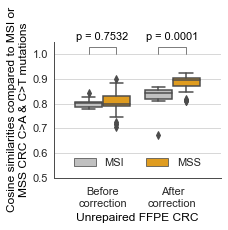

In [36]:
## using C>A and C>T
C2A_C2T_ind =["C>A" == i or "C>T" == i for i in FFPE_profiles["Basic_types"]]
comparison_unrepaired_profiles_MSI_MSS(ind = C2A_C2T_ind, tag = "C>A & C>T", file = "./Figures/SFig15a.pdf")

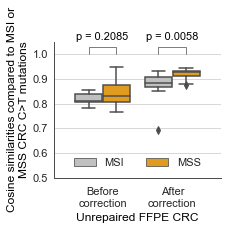

In [37]:
## Using C>T mutations
comparison_unrepaired_profiles_MSI_MSS(ind = C2T_ind, tag = "C>T", file = "./Figures/SFig15b.pdf")

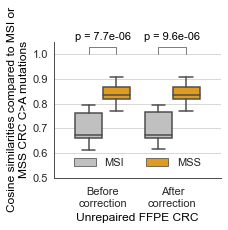

In [38]:
## using C>A 
C2A_ind =["C>A" == i for i in FFPE_profiles["Basic_types"]]
comparison_unrepaired_profiles_MSI_MSS(ind = C2A_ind, tag = "C>A", file = "./Figures/SFig15c.pdf")

In [39]:
## similarities of C>A mutations before and after correction.
C2A_ind =["C>A" == i for i in FFPE_profiles["Basic_types"]]
cosine_similarity(unrepaired_before_correction[C2A_ind].reshape(1,sum(C2A_ind)),
                  unrepaired_after_correction[C2A_ind].reshape(1,sum(C2A_ind)))

array([[0.99998723]])